In [47]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [25]:
data = pd.read_csv("Final_Data.csv", index_col="Date")
data

,Year,Month,Day,Wind Speed at 2 Meters (m/s),Temperature at 2M(C),2Dew/Frost 2M(C),Earth Skin Temperature (C),Temperature at 2M Min (C),Temperature at 2M Range,Temperature 2M Max(C),...,Feels_Like_Temp,Daily_Temp_Range,Frost_Day,Dew_Point,Pressure_7d_avg,Pressure_Anomaly,Wind_U,Wind_V,Wind_Gust_Diff,Likely_Snow
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0.91,-1.55,-6.74,-3.16,-7.05,13.12,6.07,...,-6.420,13.12,True,-6.420,NaN,NaN,-0.201840,1.718185,3.05,False
2000-01-02,2000,1,2,0.96,-0.79,-6.73,-2.85,-4.51,11.00,6.49,...,-6.910,11.00,True,-6.910,NaN,NaN,-0.205340,1.747980,2.46,False
2000-01-03,2000,1,3,0.95,-1.62,-6.76,-3.00,-7.41,13.45,6.04,...,-6.412,13.45,True,-6.412,NaN,NaN,1.142570,-1.467696,3.12,False
2000-01-04,2000,1,4,0.90,-1.15,-7.69,-3.06,-6.51,13.68,7.17,...,-7.442,13.68,True,-7.442,NaN,NaN,-0.204174,1.738049,3.09,False
2000-01-05,2000,1,5,0.90,-1.44,-7.59,-2.92,-6.82,13.28,6.46,...,-7.282,13.28,True,-7.282,NaN,NaN,-0.444006,-1.754696,3.40,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,2024,12,24,0.78,-0.27,-4.85,-2.25,-3.97,10.22,6.25,...,-4.946,10.22,True,-4.946,67.387143,0.002857,-1.038745,-1.269098,3.95,False
2024-12-25,2024,12,25,0.92,-0.54,-2.58,-1.39,-3.91,9.37,5.46,...,-2.964,9.37,True,-2.964,67.381429,0.048571,-1.292436,-1.486778,4.16,False
2024-12-26,2024,12,26,0.61,0.86,-5.18,-1.14,-4.73,12.38,7.65,...,-5.116,12.38,True,-5.116,67.397143,0.232857,-0.260908,-1.293958,2.63,False


In [26]:
df = data.fillna(method="ffill")

C:\Users\user\AppData\Local\Temp\ipykernel_17480\2669503440.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data.fillna(method="ffill")


### Define numeric features 

In [27]:

numeric_features = df.select_dtypes(include=['number']).columns

selector = VarianceThreshold(threshold=0.5)  
filtered = selector.fit_transform(df[numeric_features])
selected_columns = df[numeric_features].columns[selector.get_support()]

print(selected_columns)

Index(['Year', 'Month', 'Day', 'Temperature at 2M(C)', '2Dew/Frost 2M(C)',
       'Earth Skin Temperature (C)', 'Temperature at 2M Min (C)',
       'Temperature at 2M Range', 'Temperature 2M Max(C)',
       'Specific Humidity at 2 M (g/kg)', 'Relative Humidity at 2 M(%)',
       'Precipitation Corrected (mm/day)', 'Wind Speed at 10 M Max (m/s)',
       'Wind Direction at 10M (Degrees)',
       'Sky Surface Shortwave Downward Irradiance', 'DayOfWeek', 'WeekOfYear',
       'Temperature at 2M(C)_7d_avg', 'Temperature at 2M(C)_30d_avg',
       'Temperature at 2M(C)_lag1', 'Relative Humidity at 2 M(%)_7d_avg',
       'Relative Humidity at 2 M(%)_30d_avg',
       'Relative Humidity at 2 M(%)_lag1', 'Feels_Like_Temp',
       'Daily_Temp_Range', 'Dew_Point', 'Wind_U', 'Wind_V', 'Wind_Gust_Diff'],
      dtype='object')


### Create lag features safely

In [28]:
df.loc[:, 'Temperature_Lag1'] = df['Temperature at 2M(C)'].shift(1)
df.loc[:, 'Temperature_Lag2'] = df['Temperature at 2M(C)'].shift(2)
df.loc[:, 'Temperature_Lag3'] = df['Temperature at 2M(C)'].shift(3)

### Create rolling average features safely

In [29]:
df.loc[:, 'Temperature_Rolling7'] = df['Temperature at 2M(C)'].rolling(window=7).mean()
df.loc[:, 'Temperature_Rolling30'] = df['Temperature at 2M(C)'].rolling(window=30).mean()
# Drop rows with NaN values (due to lagging and rolling)
df = df.dropna().reset_index(drop=True)
# Check the new columns
print(df[['Temperature at 2M(C)', 'Temperature_Lag1', 'Temperature_Lag2', 'Temperature_Lag3', 'Temperature_Rolling7']].head())

   Temperature at 2M(C)  Temperature_Lag1  Temperature_Lag2  Temperature_Lag3  \
0                 -3.90             -4.45             -4.64             -3.70   
1                 -3.58             -3.90             -4.45             -4.64   
2                 -4.22             -3.58             -3.90             -4.45   
3                 -4.27             -4.22             -3.58             -3.90   
4                 -3.66             -4.27             -4.22             -3.58   

   Temperature_Rolling7  
0             -3.795714  
1             -3.787143  
2             -3.917143  
3             -4.108571  
4             -4.102857  


# Daily weather prediciton model

In [30]:
# Define X and y
X = df[selected_columns]    # Features
y = df['Temperature at 2M(C)']  # Target to predict (daily temp)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Random Forest

In [31]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

### Predict

In [32]:
y_pred = model.predict(X_test_scaled)

### Evaluate

In [33]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.00
MSE: 0.00
R² Score: 1.00


In [34]:
# Select the latest row of those features from your dataframe
latest_data = df[selected_columns].iloc[-1:]

# Scale the input using the trained scaler
latest_data_scaled = scaler.transform(latest_data)

# Predict the temperature
forecast = model.predict(latest_data_scaled)

print(f"Predicted Temperature for Tomorrow: {forecast[0]:.2f} °C")


Predicted Temperature for Tomorrow: 3.33 °C


###  Plot Actual vs Predicted

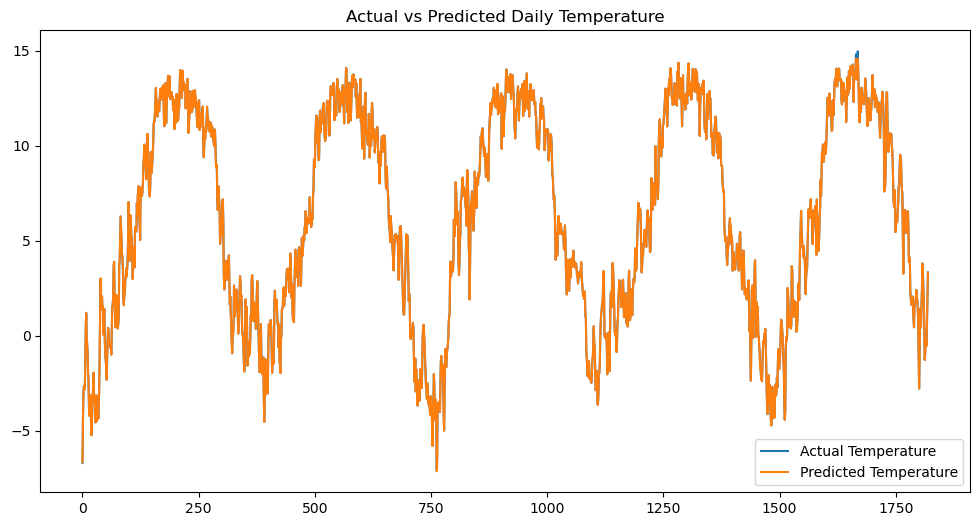

In [35]:

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.legend()
plt.title('Actual vs Predicted Daily Temperature')
plt.show()

### Define Features and Multiple Targets

In [36]:
if df.select_dtypes(include='object').shape[1] > 0:
    df = pd.get_dummies(df)  # One-hot encode categorical columns

# Split Features and Targets
X = df.drop(columns=['Temperature at 2M(C)', 'Relative Humidity at 2 M(%)', 
                     'Precipitation Corrected (mm/day)', 'Wind Speed at 10 M Max (m/s)'])

y = df[['Temperature at 2M(C)', 'Relative Humidity at 2 M(%)', 
        'Precipitation Corrected (mm/day)', 'Wind Speed at 10 M Max (m/s)']]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Multi-Output Model

In [38]:
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
multi_model = MultiOutputRegressor(base_model)

multi_model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

### Predictions

In [39]:
y_pred = multi_model.predict(X_test_scaled)

### Evaluation

In [40]:

for idx, col in enumerate(y.columns):
    print(f"--- {col} ---")
    print("RMSE:", np.sqrt(mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx])))
    print("R2 Score:", r2_score(y_test.iloc[:, idx], y_pred[:, idx]))
    print()


--- Temperature at 2M(C) ---
RMSE: 0.24128360180501293
R2 Score: 0.9979618402882331

--- Relative Humidity at 2 M(%) ---
RMSE: 2.386819345082581
R2 Score: 0.9608345167625343

--- Precipitation Corrected (mm/day) ---
RMSE: 1.9687985914251178
R2 Score: 0.6298912206731558

--- Wind Speed at 10 M Max (m/s) ---
RMSE: 0.04547228557588133
R2 Score: 0.9977690383347257



### weather classification

In [41]:

def classify_weather(temperature, humidity, precipitation, wind_speed, dew_point): 
    if temperature < 0:
        # Freezing temperatures, likely snow
        return "Snowy"
    elif 0 <= temperature < 10:
        # Cold weather, could be cloudy or overcast
        if precipitation > 1:  # Some precipitation
            return "Rainy"
        elif wind_speed > 5:  # High winds
            return "Windy"
        else:
            return "Cloudy"
    elif 10 <= temperature < 20:
        # Mild weather, partly cloudy or sunny
        if precipitation > 1:
            return "Rainy"
        elif humidity > 80:  # High humidity
            return "Foggy"
        else:
            return "Partly Cloudy"
    elif 20 <= temperature < 30:
        # Warm, likely sunny
        if humidity > 60:  # Higher humidity
            return "Humid"
        elif wind_speed > 5:
            return "Windy"
        else:
            return "Sunny"
    else:
        # Hot weather, possibly thunderstorms
        if precipitation > 5:
            return "Thunderstorm"
        elif humidity > 70:
            return "Humid"
        else:
            return "Sunny"

### Example usage

In [42]:

predicted_temperature = 35  # Example temperature
humidity = 50  # Example humidity in percentage
precipitation = 0.5  # Example precipitation in mm/day
wind_speed = 5.0  # Example wind speed in m/s
dew_point = 5.0  # Example dew point in Celsius

weather_type = classify_weather(predicted_temperature, humidity, precipitation, wind_speed, dew_point)
print(f"Predicted Weather: {weather_type}")


Predicted Weather: Sunny


#

#

# Extreme weather prediction

In [43]:
# Define extreme weather conditions
selected_features = [
    'Temperature at 2M(C)',
    'Precipitation Corrected (mm/day)',
    'Wind Speed at 10 M (m/s)',
    'Relative Humidity at 2 M(%)'
]

df['Extreme_Weather'] = 0

# High temperature (>35°C)
df.loc[df['Temperature at 2M(C)'] > 35, 'Extreme_Weather'] = 1

# Heavy precipitation (>50mm/day)
df.loc[df['Precipitation Corrected (mm/day)'] > 50, 'Extreme_Weather'] = 1

# High wind speed (>20 m/s)
df.loc[df['Wind Speed at 10 M (m/s)'] > 20, 'Extreme_Weather'] = 1

# High humidity (>90%)
df.loc[df['Relative Humidity at 2 M(%)'] > 90, 'Extreme_Weather'] = 1


In [44]:
X = df[selected_features]
y = df['Extreme_Weather']

### Split data into training and testing sets

In [45]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Initialize the model

In [48]:

logreg = LogisticRegression(max_iter=1000)

### Train the model

In [49]:

logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

## Predict model

In [50]:
y_pred = logreg.predict(X_test)

### Evaluate the model

In [51]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1599
           1       1.00      1.00      1.00       221

    accuracy                           1.00      1820
   macro avg       1.00      1.00      1.00      1820
weighted avg       1.00      1.00      1.00      1820



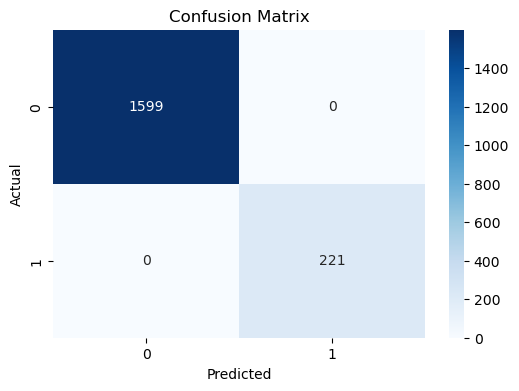

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#

#

# seasonality predictions

In [94]:

df = pd.read_csv('Final_Data.csv', index_col = 'Date')
selected_columns = ['Year', 'Month', 'Day', 'Temperature at 2M(C)', '2Dew/Frost 2M(C)', 
                    'Earth Skin Temperature (C)', 'Temperature at 2M Min (C)', 
                    'Temperature at 2M Range', 'Temperature 2M Max(C)', 
                    'Specific Humidity at 2 M (g/kg)', 'Relative Humidity at 2 M(%)', 
                    'Precipitation Corrected (mm/day)', 'Wind Speed at 10 M Max (m/s)', 
                    'Wind Direction at 10M (Degrees)', 'Sky Surface Shortwave Downward Irradiance',
                    'Temperature at 2M(C)_7d_avg', 'Temperature at 2M(C)_30d_avg', 
                    'Temperature at 2M(C)_lag1', 'Relative Humidity at 2 M(%)_7d_avg', 
                    'Relative Humidity at 2 M(%)_30d_avg', 'Relative Humidity at 2 M(%)_lag1', 
                    'Feels_Like_Temp', 'Daily_Temp_Range', 'Dew_Point', 'Wind_U','Season', 
                    'Wind_V', 'Wind_Gust_Diff']


### Prepare features (X) and target (y)

In [95]:
# Check if 'Season' column has all classes
print("Class distribution in dataset:")
print(df['Season'].value_counts())

# Split features and target
X = df[selected_columns].drop('Season', axis=1)
y = df['Season']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Class distribution in dataset:
Season
Spring    2300
Summer    2300
Autumn    2275
Winter    2254
Name: count, dtype: int64


### Split data into train and test

In [96]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Scale features 


In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Build and train the XGBoost model

In [98]:

model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    objective='multi:softmax',  # Since we have multiple classes
    num_class=4  # Spring, Summer, Autumn, Winter
)

model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=4, ...)

### Predict and evaluate

In [99]:

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Autumn       1.00      1.00      1.00       455
      Spring       1.00      1.00      1.00       460
      Summer       1.00      1.00      1.00       460
      Winter       1.00      1.00      1.00       451

    accuracy                           1.00      1826
   macro avg       1.00      1.00      1.00      1826
weighted avg       1.00      1.00      1.00      1826

Confusion Matrix:
[[455   0   0   0]
 [  0 460   0   0]
 [  0   0 460   0]
 [  0   0   0 451]]
